Exploratory data work, used to find project idea and find viability

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import nflreadpy as nfl

In [234]:
input_files = [f'Data/input_2023_w{i:02}.csv' for i in range(1, 19)]
inputs = pd.concat([pd.read_csv(file) for file in input_files], ignore_index=True)
input_players = inputs[['player_name', 'player_position']].drop_duplicates()

# make plays that are going left go right instead
going_left = inputs['play_direction'] == 'left'
inputs.loc[going_left, 'x'] = 120 - inputs.loc[mask, 'x']
inputs.loc[going_left, 'y'] = 53.3 - inputs.loc[mask, 'y']
inputs.loc[going_left, 'ball_land_x'] = 120 - inputs.loc[mask, 'ball_land_x']
inputs.loc[going_left, 'ball_land_y'] = 53.3 - inputs.loc[mask, 'ball_land_y']
inputs.loc[going_left, 'o'] = (180 + inputs.loc[going_left, 'o']) % 360
inputs.loc[going_left, 'dir'] = (180 + inputs.loc[going_left, 'dir']) % 360

# Do we need outputs?
#output_files = [f'Data/output_2023_w{i:02}.csv' for i in range(1, 19)]
#outputs = pd.concat([pd.read_csv(file) for file in output_files], ignore_index=True)

players = pd.DataFrame(nfl.load_players()[['gsis_id', 'display_name']])
players.columns = ['player_id', 'player_name']
player_crosswalk = pd.merge(players, inputs[['player_name', 'player_position', 'nfl_id']].drop_duplicates(), on = 'player_name', how = 'inner')

pbp_data = pd.read_parquet('Data/play_by_play_2023.parquet')
pbp_data = pbp_data[['play_id', 'old_game_id', 
                 'epa', 'qb_hit', 'pass_defense_1_player_id', 'pass_defense_1_player_name', 
                 'pass_defense_2_player_id', 'pass_defense_2_player_name',
                 'cp', 'xpass']]
pbp_data['play_id'] = pbp_data['play_id'].astype(int)
pbp_data['game_id'] = pbp_data['old_game_id'].astype(int)

pass_deflections = pbp_data[
    pd.notna(pbp_data['pass_defense_1_player_id']) |
    pd.notna(pbp_data['pass_defense_2_player_id'])
]
pass_deflections['pass_deflection'] = 1
pass_deflections = pd.merge(pass_deflections, player_crosswalk, left_on = 'pass_defense_1_player_id', right_on = 'player_id', how = 'left')

supplementary_data = pd.read_csv('Data/supplementary_data.csv')
valid_plays = supplementary_data[supplementary_data['season'] == 2023]
valid_plays = pd.merge(valid_plays, pbp_data, on=['game_id', 'play_id'], how='inner')
valid_plays['interception'] = np.where(valid_plays['pass_result'] == 'IN', 1, 0)
valid_plays = pd.merge(valid_plays, pass_deflections[['game_id', 'play_id', 'pass_deflection', 'player_position']], on=['game_id', 'play_id'], how='left')
valid_plays['pass_deflection'] = valid_plays['pass_deflection'].fillna(0)

C:\Users\jerem\AppData\Local\Temp\ipykernel_22792\2646430880.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_deflections['pass_deflection'] = 1
C:\Users\jerem\AppData\Local\Temp\ipykernel_22792\2646430880.py:28: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_data = pd.read_csv('Data/supplementary_data.csv')


In [235]:
print(len(valid_plays)) #14108 plays
print(valid_plays.team_coverage_man_zone.value_counts()) # 10092 zone plays
valid_plays = valid_plays[valid_plays.team_coverage_man_zone == 'ZONE_COVERAGE']
print(sum(valid_plays.pass_length > 5))  # pass must go beyond 5 yards
valid_plays = valid_plays[valid_plays.pass_length > 5] # 5306 plays beyond 5 yards

14112
team_coverage_man_zone
ZONE_COVERAGE    10095
MAN_COVERAGE      4014
Name: count, dtype: int64
5309


In [236]:
valid_plays.route_of_targeted_receiver.value_counts()

route_of_targeted_receiver
HITCH     1209
GO         838
OUT        829
IN         629
POST       574
SLANT      413
CROSS      382
CORNER     288
FLAT        58
ANGLE       40
WHEEL       40
SCREEN       9
Name: count, dtype: int64

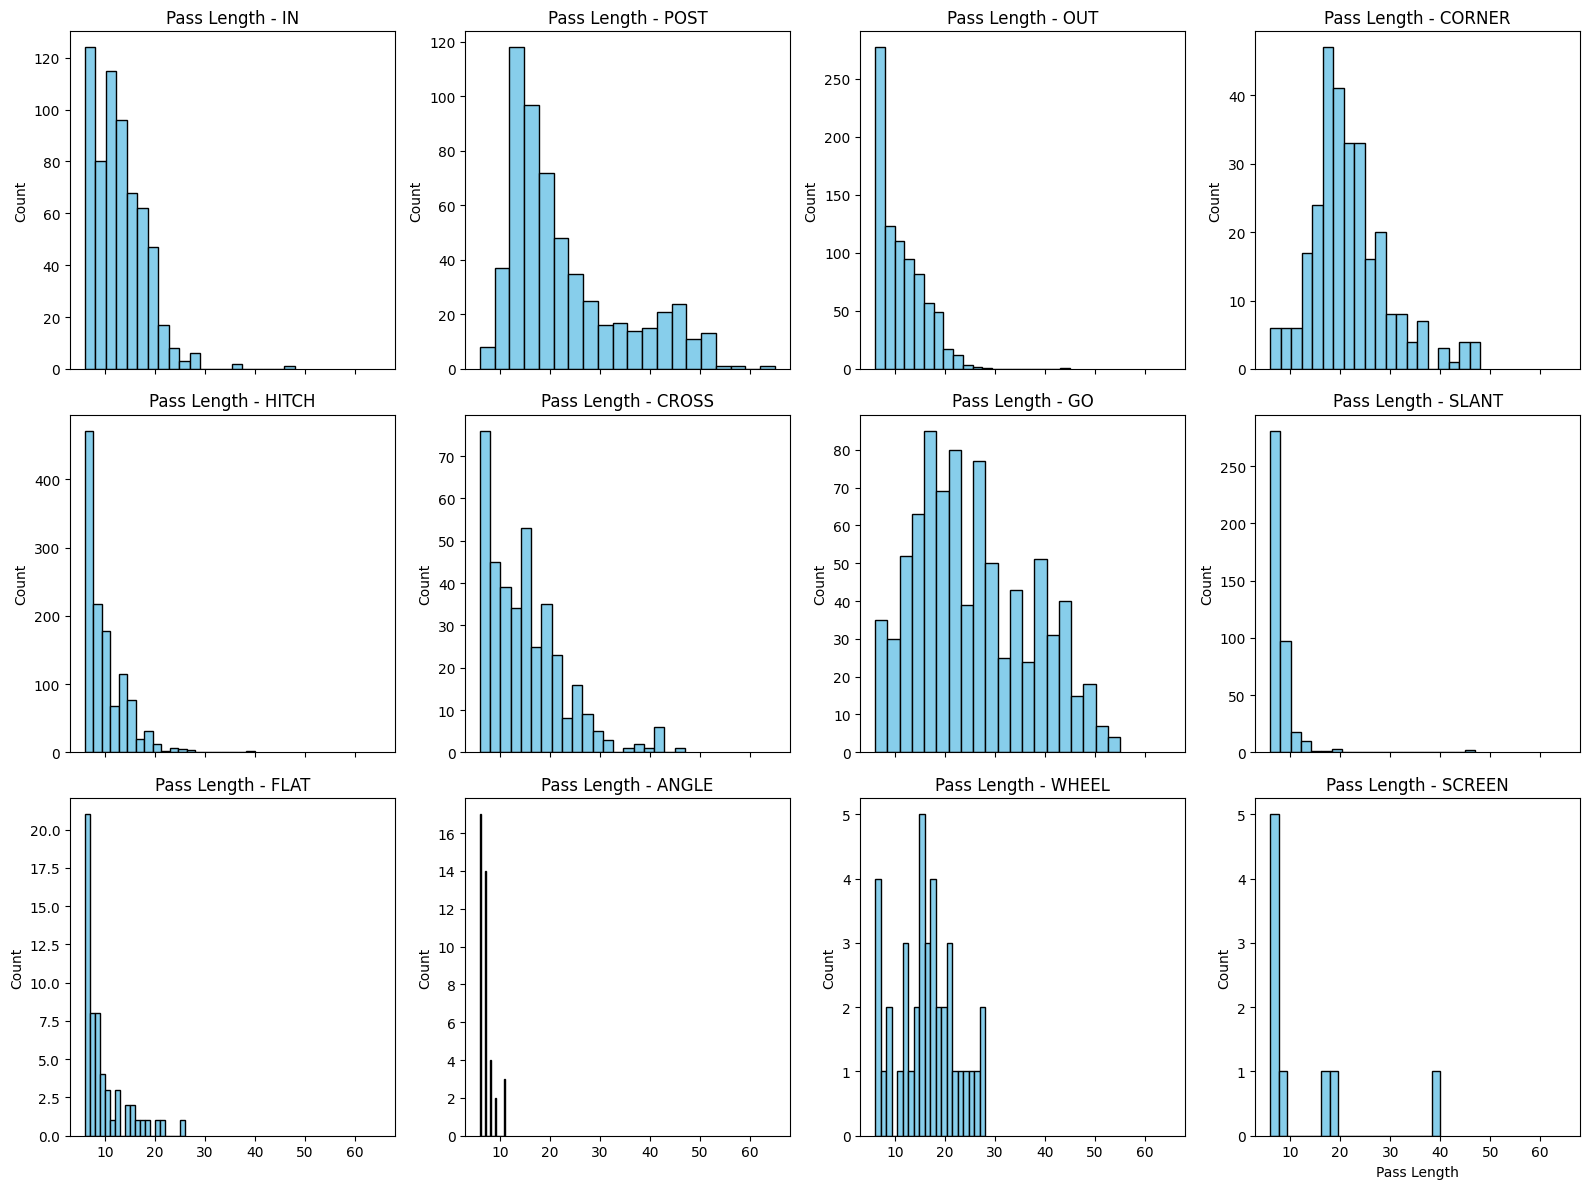

In [237]:
routes = valid_plays['route_of_targeted_receiver'].unique()
num_routes = len(routes)

# Define grid size: 3 rows x 4 columns
rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True, sharey=False)
axes = axes.flatten()  # Flatten 2D array for easy iteration

for i, route in enumerate(routes):
    subset = valid_plays[valid_plays['route_of_targeted_receiver'] == route]
    axes[i].hist(subset['pass_length'], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Pass Length - {route}")
    axes[i].set_ylabel("Count")

# Hide any empty subplots if number of routes < 12
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.xlabel("Pass Length")
plt.tight_layout()
plt.show()


In [ ]:
games=data0['game_id'].unique().tolist()

In [238]:
valid_plays[(valid_plays['interception'] == 1) & (valid_plays['route_of_targeted_receiver'] == 'IN')]

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,qb_hit,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,cp,xpass,interception,pass_deflection,player_position
62,2023091000,2023,1,09/10/2023,13:00:00,ATL,CAR,661,(1:10) (Shotgun) B.Young pass short middle int...,1,...,0.0,00-0034675,J.Bates,None,None,0.727499,0.678232,1,1.0,SS
484,2023091008,2023,1,09/10/2023,16:25:00,CHI,GB,3377,(12:53) (Shotgun) J.Fields pass short middle i...,4,...,1.0,00-0037074,Q.Walker,None,None,0.501754,0.989474,1,1.0,OLB
868,2023091400,2023,2,09/14/2023,20:15:00,PHI,MIN,685,(3:04) (Shotgun) J.Hurts pass deep middle inte...,1,...,0.0,00-0037301,Th.Jackson,None,None,0.519777,0.948981,1,1.0,FS
1207,2023091706,2023,2,09/17/2023,13:00:00,TB,CHI,3981,"(1:17) (No Huddle, Shotgun) J.Fields pass shor...",4,...,0.0,00-0036411,A.Winfield,00-0038820,C.Izien,0.692632,0.970429,1,1.0,FS
1998,2023092404,2023,3,09/24/2023,13:00:00,JAX,HOU,3183,(2:28) (Shotgun) T.Lawrence pass short middle ...,3,...,0.0,00-0035276,B.Cashman,None,None,0.657171,0.988361,1,1.0,ILB
2427,2023092412,2023,3,09/24/2023,20:20:00,LV,PIT,1234,(12:27) (Shotgun) J.Garoppolo pass short middl...,2,...,1.0,00-0034514,L.Wallace,None,None,0.592747,0.624884,1,1.0,CB
2580,2023092800,2023,4,09/28/2023,20:15:00,GB,DET,3791,(4:15) (Shotgun) J.Love pass short middle inte...,4,...,0.0,00-0036748,J.Jacobs,None,None,0.543912,0.930649,1,1.0,CB
2589,2023092800,2023,4,09/28/2023,20:15:00,GB,DET,1156,(14:01) J.Love pass deep middle intended for C...,2,...,0.0,00-0033914,A.Anzalone,00-0036748,J.Jacobs,0.711967,0.417794,1,1.0,OLB
2649,2023100100,2023,4,10/01/2023,09:30:00,JAX,ATL,1495,(4:31) (Shotgun) D.Ridder pass short middle in...,2,...,0.0,00-0036941,A.Cisco,None,None,0.725741,0.644604,1,1.0,FS
2657,2023100100,2023,4,10/01/2023,09:30:00,JAX,ATL,1429,(4:42) (Shotgun) D.Ridder pass short right int...,2,...,0.0,00-0034203,Dari.Williams,None,None,0.750951,0.568922,1,1.0,CB


In [250]:
game_id = 2023111902
play_id = 995
select_game = inputs[inputs['game_id'] == game_id]
plays = select_game[select_game['play_id'] == play_id]
frame_ids = sorted(plays['frame_id'].unique())

from PIL import Image

# Function to draw the football field
def draw_football_field(ax):
    # Draw field boundaries
    ax.plot([0, 120], [0, 0], color='white', linewidth=2)
    ax.plot([0, 120], [53.3, 53.3], color='white', linewidth=2)
    ax.plot([10, 10], [0, 53.3], color='white', linewidth=2)
    ax.plot([110, 110], [0, 53.3], color='white', linewidth=2)
    ax.plot([60, 60], [0, 53.3], color='white', linewidth=2)

    # Shade end zones
    ax.axvspan(0, 10, facecolor='blue', alpha=0.2)
    ax.axvspan(110, 120, facecolor='red', alpha=0.2)

    # Draw yard lines
    for x in range(20, 110, 10):
        ax.plot([x, x], [0, 53.3], color='white', linestyle='--', linewidth=1)

# Create a directory to save the frame images
os.makedirs('frames', exist_ok=True)

print(f"Total frames to process: {len(frame_ids)}")

# Check for unique player roles in the data
unique_roles = plays['player_role'].dropna().unique()
print(f"Unique player roles: {unique_roles}")

# Define a color map for common player roles
role_colors = {
    'Offense': 'red',
    'Defense': 'blue',
    'Football': 'gold',
    'Ball': 'gold',
    'QB': 'darkred',
    'WR': 'orange',
    'RB': 'yellow',
    'TE': 'goldenrod',
    'OL': 'lightcoral',
    'LB': 'lightblue',
    'DB': 'cyan',
    'DL': 'navy',
    'S': 'deepskyblue',
    'CB': 'aqua',
    'K': 'purple',
    'P': 'violet',
    'Targeted Receiver': 'lime'
}

# Dynamically create a color map based on the roles found in the data
dynamic_role_map = {}
for role in unique_roles:
    role_str = str(role)
    if role_str in role_colors:
        dynamic_role_map[role] = role_colors[role_str]
    elif 'target' in role_str.lower() or 'receiver' in role_str.lower():
        dynamic_role_map[role] = 'lime'
    elif 'offense' in role_str.lower() or 'off' in role_str.lower():
        dynamic_role_map[role] = 'red'
    elif 'defense' in role_str.lower() or 'def' in role_str.lower():
        dynamic_role_map[role] = 'blue'
    elif 'ball' in role_str.lower():
        dynamic_role_map[role] = 'gold'
    else:
        # Assign a unique color for other roles
        colors = ['green', 'purple', 'orange', 'yellow', 'pink', 'gray', 'cyan', 'magenta']
        color_index = hash(role_str) % len(colors)
        dynamic_role_map[role] = colors[color_index]

print(f"Color mapping: {dynamic_role_map}")

# Loop through each frame and create a plot
for i, frame_id in enumerate(frame_ids):
    # Get the data for the current frame
    data_frame = plays[plays['frame_id'] == frame_id].reset_index(drop=True)

    if len(data_frame) == 0:
        continue

    # Get play information from the first row
    game_id = data_frame.loc[0, 'game_id']
    play_id = data_frame.loc[0, 'play_id']
    play_direction = data_frame.loc[0, 'play_direction']

    fig, ax = plt.subplots(figsize=(16, 8)) # Slightly wider plot for the legend
    ax.set_facecolor('green')
    draw_football_field(ax)

    # Plot regular players
    if 'player_role' in data_frame.columns:
        # Identify targeted receivers
        targeted_receivers = data_frame[
            data_frame['player_role'].str.contains('target|receiver', case=False, na=False) |
            data_frame['player_name'].str.contains('target|receiver', case=False, na=False)
        ]

        # Plot regular players (not targeted receivers)
        regular_players = data_frame[~data_frame.index.isin(targeted_receivers.index)]

        current_roles = regular_players['player_role'].dropna().unique()
        for role in current_roles:
            if role in dynamic_role_map:
                role_data = regular_players[regular_players['player_role'] == role]
                ax.scatter(role_data['x'], role_data['y'],
                           c=dynamic_role_map[role], s=120, edgecolor='black',
                           alpha=0.8, label=str(role), linewidth=1.5)

        # Plot the Targeted Receiver with a special style
        if not targeted_receivers.empty:
            for idx, receiver in targeted_receivers.iterrows():
                # Use a prominent marker with a bright green color
                ax.scatter(receiver['x'], receiver['y'],
                           c='lime', s=300, edgecolor='white',
                           alpha=1.0, label='Targeted Receiver' if idx == targeted_receivers.index[0] else "",
                           marker='*', linewidth=3)
                           
                # Display the name with a text label
                ax.text(receiver['x'], receiver['y'] + 3,
                        f"TARGET\n{receiver['player_name']}",
                        ha='center', va='bottom', fontsize=8, fontweight='bold',
                        color='white',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8, edgecolor='white'))
        
        # Set the legend
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.,
                  fontsize=10, framealpha=0.9)

    else:
        # Fallback if the player_role column is not found
        ax.scatter(data_frame['x'], data_frame['y'], s=120,
                   color='white', edgecolor='black', alpha=0.8, label='Players')

    # Plot the ball's landing spot if it exists
    if 'ball_land_x' in data_frame.columns and not pd.isna(data_frame.loc[0, 'ball_land_x']):
        ax.scatter(data_frame.loc[0, 'ball_land_x'], data_frame.loc[0, 'ball_land_y'],
                   color='yellow', s=400, marker='*', edgecolor='black',
                   alpha=1.0, label='Ball Landing Spot', linewidth=2)

    # Highlight the Quarterback (if present)
    if 'player_role' in data_frame.columns:
        qb_players = data_frame[data_frame['player_role'].str.contains('QB|Quarterback', case=False, na=False)]
        if not qb_players.empty:
            for idx, qb in qb_players.iterrows():
                ax.scatter(qb['x'], qb['y'],
                           c='darkred', s=200, edgecolor='gold',
                           alpha=1.0, label='QB' if idx == qb_players.index[0] else "",
                           marker='D', linewidth=2)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)

    # Add play information to the title
    title_text = f'Game: {game_id}, Play: {play_id}, Frame: {frame_id}\nPlay Direction: {play_direction.upper()}'
    if not targeted_receivers.empty:
        receiver_names = ', '.join(targeted_receivers['player_name'].dropna().unique())
        title_text += f'\nTargeted Receiver: {receiver_names}'

    ax.set_title(title_text, fontsize=12, pad=20, fontweight='bold')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add a grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--')

    # Adjust layout to fit everything
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    # Save the frame
    plt.savefig(f'frames/frame_{i:06d}.png', dpi=120, bbox_inches='tight',
                facecolor='green', edgecolor='none')
    plt.close(fig)

    # Display progress
    if (i + 1) % 10 == 0 or (i + 1) == len(frame_ids):
        print(f'Processed {i + 1}/{len(frame_ids)} frames')

# Create the GIF animation
print("Creating animation...")
frames = []
for i in range(len(frame_ids)):
    try:
        frame = Image.open(f'frames/frame_{i:06d}.png')
        frames.append(frame)
    except FileNotFoundError:
        print(f'Frame {i:06d} not found')

if frames:
    frames[0].save('football_tracking.gif', save_all=True,
                   append_images=frames[1:], duration=100, loop=0)
    print("Animation created successfully! File: football_tracking.gif")
    print(f"Total frames in animation: {len(frames)}")
else:
    print("No frames found to create animation.")


Total frames to process: 35
Unique player roles: ['Defensive Coverage' 'Other Route Runner' 'Passer' 'Targeted Receiver']
Color mapping: {'Defensive Coverage': 'blue', 'Other Route Runner': 'gray', 'Passer': 'gray', 'Targeted Receiver': 'lime'}
Processed 10/35 frames
Processed 20/35 frames
Processed 30/35 frames
Processed 35/35 frames
Creating animation...
Animation created successfully! File: football_tracking.gif
Total frames in animation: 35


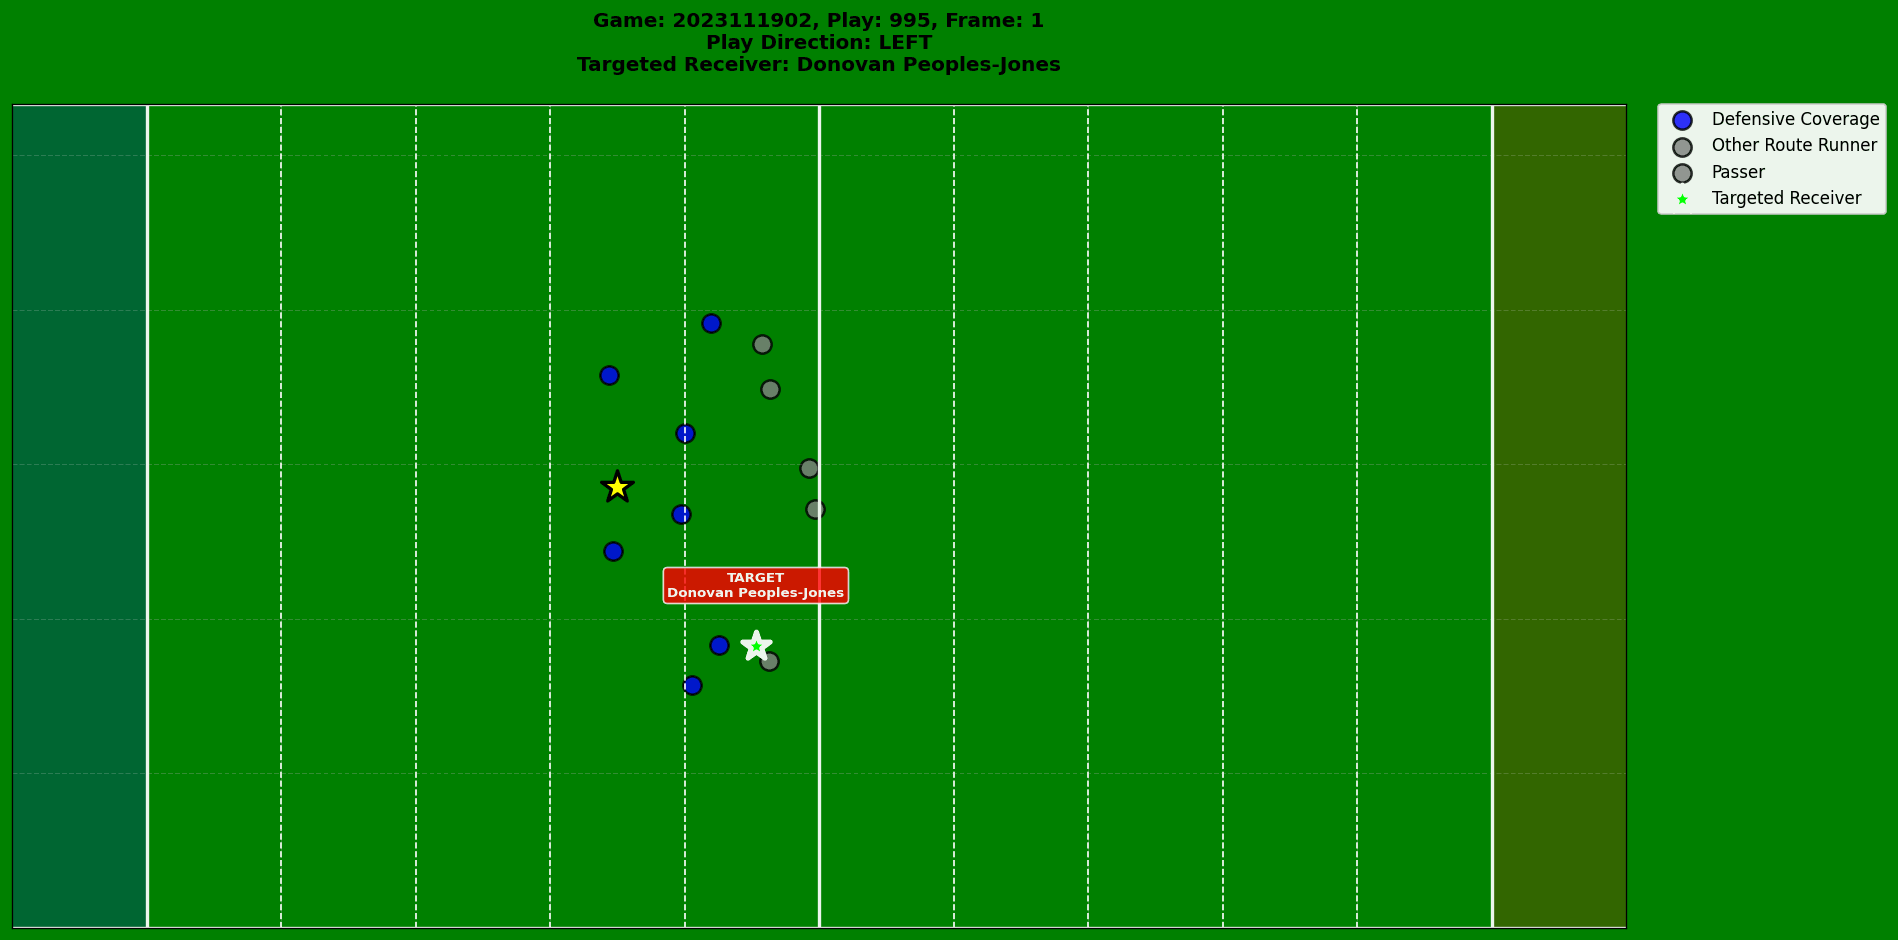

In [251]:
from IPython.display import Image
Image(open('./football_tracking.gif','rb').read())